# Tutorial 1: Metamodeling

A metasurface consists of subwavelength scatterers, called meta-atoms. When we model the optical behavior of the metasurface, it would take a long time to compute the transmission coefficient of individual scatterers. Here, we use a metamodel to model the complex transmission coefficient of such scatterers to achieve considerable speed up. This method allows design of large area metasurfaces while maintaining good accuracy for modeling the optical behavior.

`metabox` enables complicated deep neural networks talored to the needs of the complex meta-atoms. This tutorial will go over some of the most useful features in `metabox` to help you design, sample, and metamodel after your meta-atoms.

In [1]:
from metabox import rcwa, utils, modeling
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# First, let's see what materials are available in the database
print(rcwa.get_avaliable_materials())

# You can also define your own materials, just go to https://refractiveindex.info/
# and download the .csv file for your material. Then, put it in the folder of your
# choice and use the following format to define your material:
# rcwa.Material('name', 'path/to/file.csv')

['quartz', 'Si3N4', 'Nb2O5', 'MoO3', 'ZrO2', 'ZnO', 'Si_visible', 'TiO2', 'Si_ir', 'N-BK7', 'GaN']


/home/huang/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Now let's define some materials for our simulations
TiO2 = rcwa.Material('Si3N4')
quartz = rcwa.Material('quartz')

# Define sampling wavelengths, here we only simulate 3 wavelength for simplicity
# In practice, you may want to simulate more wavelengths for better sampling density.
incidence = utils.Incidence(wavelength=np.linspace(460e-9, 700e-9, 3))

# Define the unit cell periodicity
periodicity = (350e-9, 350e-9)

# Define RCWA simulation configuration
sim_config = rcwa.SimConfig(
    xy_harmonics=(7, 7), # Fourier orders in x and y
    resolution=256, # grid resolution per periodicity
    return_tensor=True, # return tensor instead of a SimulationResult object
    minibatch_size=10 # number of simulations to run in parallel
)

# Instantiate a `Feature` to parameterize the width of the square
width = utils.Feature(vmin=0, vmax=periodicity[0], name="radius", sampling=100)
square = rcwa.Rectangle(material=TiO2, x_width = width, y_width = width)
patterned_layer = rcwa.Layer(material=1, thickness=800e-9, shapes=[square])
substrate = rcwa.Layer(material=quartz, thickness=1000e-9)
cell = rcwa.UnitCell(
    layers=[patterned_layer, substrate], 
    periodicity=periodicity,
)
protocell = rcwa.ProtoUnitCell(cell)

sim_lib = modeling.sample_protocell(
    protocell=protocell,
    incidence=incidence,
    sim_config=sim_config,
)    

sim_lib.save('TiO2_square_sim_lib','./example_folder', overwrite=True)

100%|██████████| 30/30 [05:56<00:00, 11.89s/it]

Saved the atom library to ./example_folder/TiO2_square_sim_lib.pkl


In [8]:
# Now that we have saved our simulations, we can load them back in
# and use them to train a metamodel neural network.
loaded_sim_lib = modeling.load_simulation_library('TiO2_square_sim_lib','./example_folder')

# Let's train a DNN with the following architecture:
# Input layer -> 10 (relu) -> 128 (tanh) -> 256 (relu) -> 256 (tanh) -> 128 (relu) -> 10 (tanh) -> Output layer
model = modeling.create_and_train_model(
    loaded_sim_lib,
    n_epochs=100,
    hidden_layer_units_list=[10, 128, 512, 512, 512, 128, 10],
    activation_list=['relu', 'tanh', 'relu', 'relu', 'relu', 'tanh', 'tanh'],
    train_batch_size=100,
)
model.save('TiO2_square_metamodel','./example_folder', overwrite=True)

100%|██████████| 100/100 [00:24<00:00,  4.02epoch/s, loss=0.0248, val_loss=0.0295]


Saved metamodel to ./example_folder/TiO2_square_metamodel


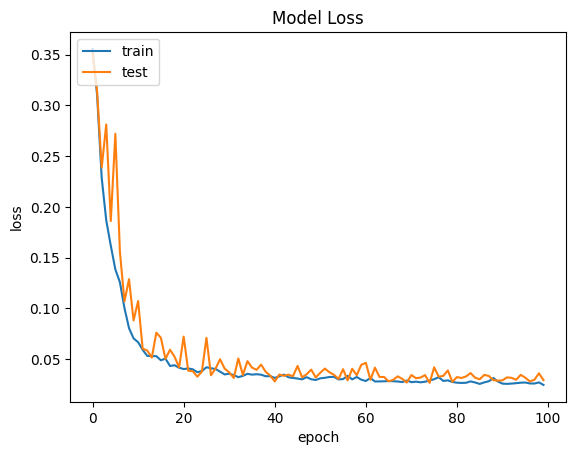

In [9]:
model.plot_training_history()

10/10 [==============================] - 0s 2ms/step


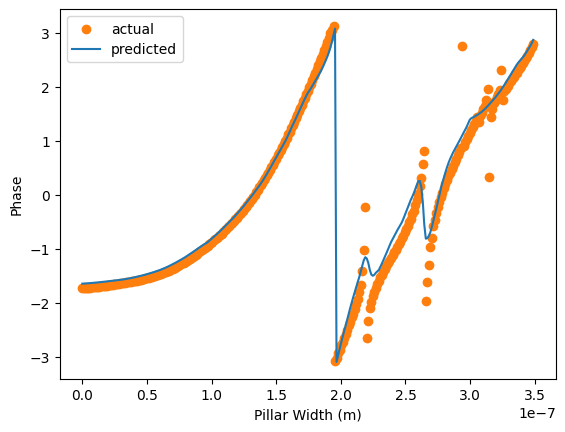

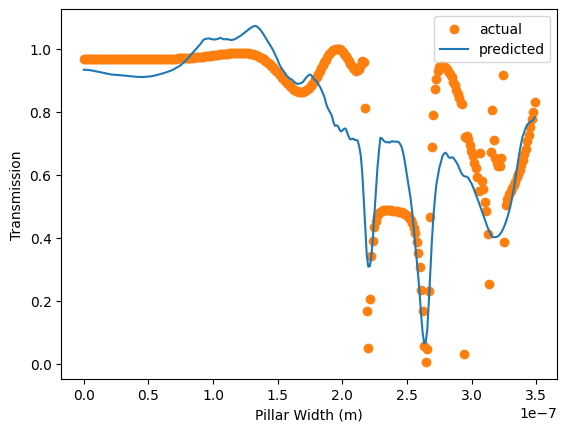

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Let's load the metamodel and compare the predictions to the atom library.
mm = modeling.load_metamodel("TiO2_square_metamodel", './example_folder')

# Load the simulated atom library to compare.
sim_lib = modeling.load_simulation_library("TiO2_square_sim_lib", './example_folder')
inputs = sim_lib.get_training_x()
outputs = sim_lib.get_training_y()

inputs = inputs[-300:-1]
outputs = outputs[-300:-1][:, 0]
prediction = mm.model.predict(inputs)[:, 0]

# Plot phase and transmission predictions
plt.xlabel("Pillar Width (m)")
plt.ylabel("Phase")
plt.scatter(inputs[:, 1], np.angle(outputs), label="actual", c="C1")
plt.plot(inputs[:, 1], np.angle(prediction), label="predicted")
plt.legend()
plt.show()


plt.xlabel("Pillar Width (m)")
plt.ylabel("Transmission")
plt.scatter(inputs[:, 1], np.abs(outputs)**2, label="actual", c="C1")
plt.plot(inputs[:, 1], np.abs(prediction)**2, label="predicted")
plt.legend()
plt.show()